<a href="https://colab.research.google.com/github/StefanHubner/MachineLearningEconomics/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
Sys.setenv("CUDA" = "cpu")
Sys.setenv("TORCH_INSTALL" = "1")
install.packages("torch", reinstall = FALSE)
torch::install_torch()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘coro’




In [3]:
install.packages("torchvision")
install.packages("luz")
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘jpeg’, ‘png’, ‘abind’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’




In [91]:
library(torch)       # computing library
library(torchvision) # for dataset
library(luz)         # for dataset loading
library(coro)        # for iterating over patches
library(ggplot2)
library(dplyr)

In [17]:
# Load MNIST dataset
train_dataset <- mnist_dataset(
  ".",
  download = TRUE,
  train = TRUE,
  transform = transform_to_tensor
)

test_dataset <- mnist_dataset(
  ".",
  download = TRUE,
  train = FALSE,
  transform = transform_to_tensor
)

# Data Loader
train_dl <- dataloader(train_dataset, batch_size = 64)
test_dl <- dataloader(test_dataset, batch_size = 64)

[1] "Y_i = 5"


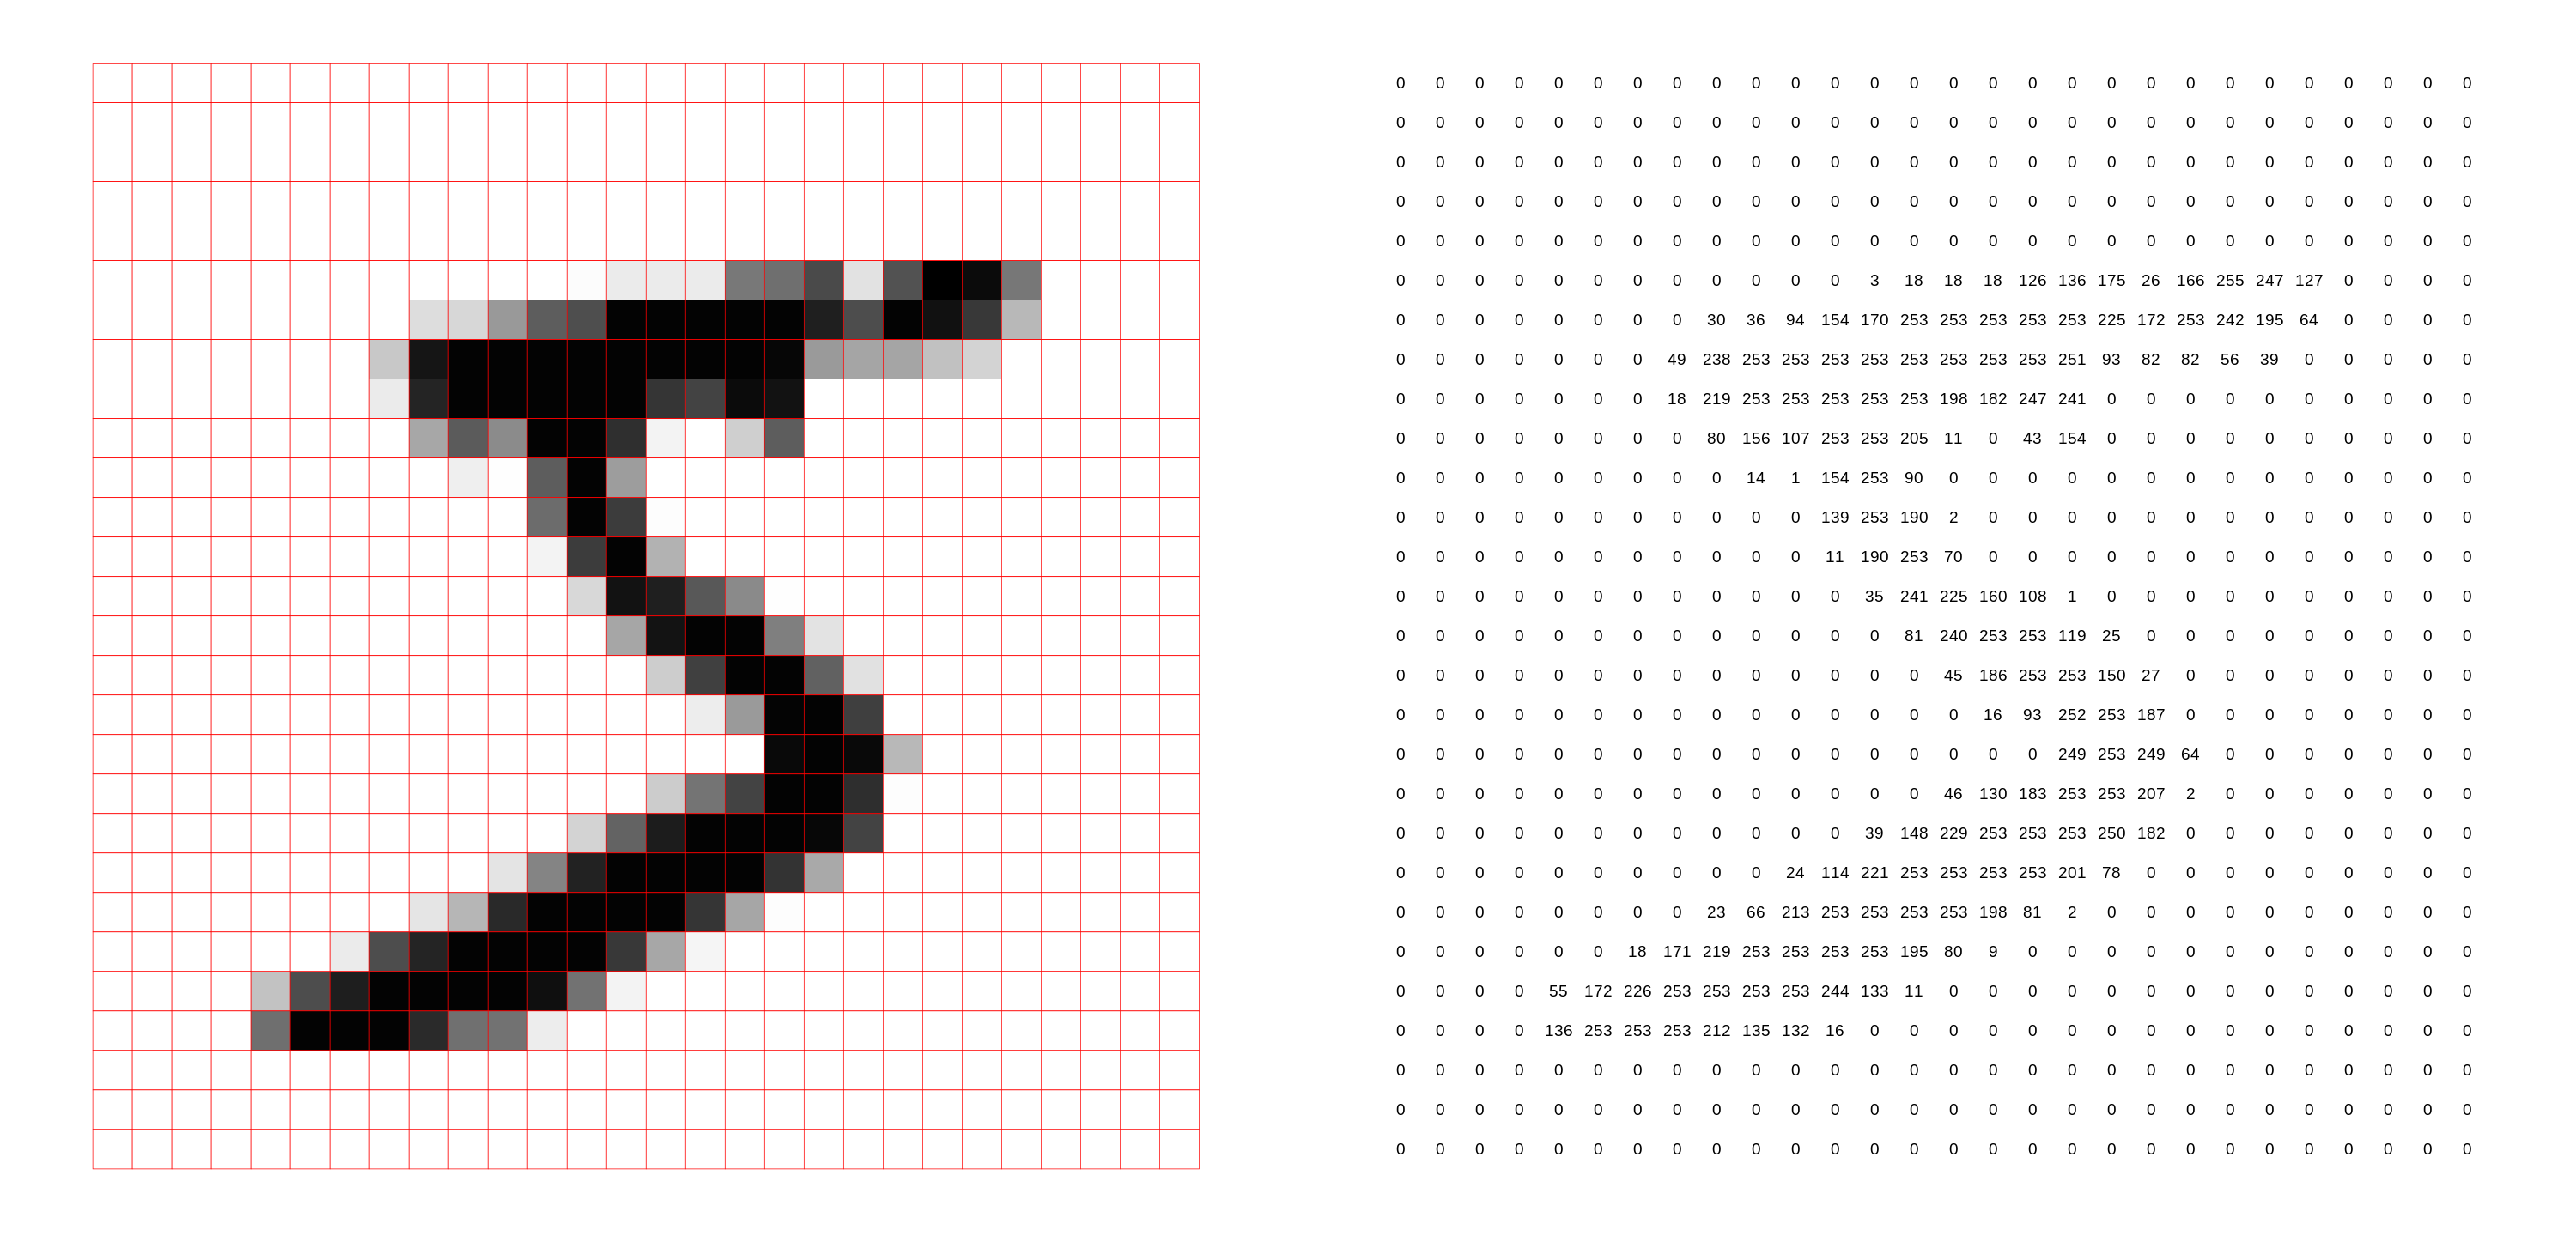

In [105]:
library(ggplot2)
library(dplyr)
library(gridExtra)

# Assuming train_dataset is already loaded and is a dataset of MNIST images
# Extract the first image data
idx <- 1
image_data <- train_dataset$data[idx, , ]

# Convert the tensor to a matrix and then to a long format data frame
image_matrix <- as.array(image_data)
image_df <- expand.grid(y = 1:28, x = 1:28)
image_df$intensity <- as.vector(image_matrix)

# Image plot
image_plot <- ggplot(image_df, aes(x = x, y = -y, fill = intensity)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "black") +
  geom_tile(color = "red", size = 0.2) +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank()) +
  coord_fixed() +
  guides(fill = FALSE)

# Text plot
text_plot <- ggplot(image_df, aes(x = x, y = -y, label = round(intensity, 2))) +
  geom_tile(fill = "white") +
  geom_text(color = "black", size = 4) +
  theme_minimal() +
  theme(axis.text = element_blank(),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        panel.border = element_blank()) +
  coord_fixed()

# Arrange both plots side by side
options(repr.plot.width = 25, repr.plot.height = 12)
grid.arrange(image_plot, text_plot, ncol = 2)

print(paste0("Y_i = ", train_dl$dataset[idx]$y - 1))

In [30]:
# Define the neural network
net <- nn_module(
  "Net",
  initialize = function() {
    self$fc1 <- nn_linear(784, 256)
    self$fc2 <- nn_linear(256, 128)
    self$fc3 <- nn_linear(128, 10)
  },
  forward = function(x) {
    x <- x$view(c(-1, 784)) # vectorise the image
    x %>%
      self$fc1() %>% # layer 1
      nnf_relu() %>% # relu
      self$fc2() %>% # layer 2
      nnf_relu() %>% # relu
      self$fc3()     # layer 3
  }
)

# Create an instance of the model
model <- net()

# Define the loss function and optimizer
loss_fn <- nn_cross_entropy_loss() # KL divergence with multinomial logit parameterisation
optimizer <- optim_adam(model$parameters)

In [32]:
# Optimiser step (Gradient descent, Newton-type minimiser)
train_batch <- function(b, model, loss_fn, optimizer) {
  optimizer$zero_grad()        # Reset gradients from previous operations
  output <- model(b$x)         # Forward pass: compute the model's output
  loss <- loss_fn(output, b$y) # Compute loss: how far off our predictions are
  loss$backward()              # Backward pass: compute gradients of loss w.r.t. model parameters
  optimizer$step()             # Update model parameters based on gradients
  loss$item()                  # Return the loss value as a number (item takes it off GPU or CPU)
}

# In the ML/AI literature it is customary to fix the number of iterations in the newton-procedure
# instead of specifying a convergence criterion
num_epochs <- 5

# Stochastic Gradient descent
# We take a step for each batch of data (i.e. 60000/64 approx. = 937 * 5 epochs approx. = 5000 steps).
for (epoch in 1:num_epochs) {
  model$train() # training mode (sets configuration for computation)
  total_loss <- 0
  total <- 0

  loop(for (b in train_dl) { # batches = data (here: size 64)
    loss <- train_batch(b, model, loss_fn, optimizer)
    total_loss <- total_loss + loss
    total <- total + 1
  })

  avg_loss <- total_loss / total
  cat(sprintf("Epoch: %d, Loss: %.4f\n", epoch, avg_loss))
}

# Save the trained model
torch_save(model, "mnist_model.pt")

Epoch: 1, Loss: 0.2284
Epoch: 2, Loss: 0.1106
Epoch: 3, Loss: 0.0717
Epoch: 4, Loss: 0.0489
Epoch: 5, Loss: 0.0349


In [88]:
# Validation function
validate_model <- function(model, test_dl, loss_fn) {
  model$eval()  # Set the model to evaluation mode (configuration for computation)
  total_loss <- 0
  total_accuracy <- 0
  total_count <- 0

  loop(for (b in test_dl) {
    output <- model(b$x) # think of the function model as xbhat, n = batchsize = 64, k = 10

    # Convert output to probabilities
    probabilities <- nnf_softmax(output, dim = 2) # phat = Lambda(xbhat)

    # get the predicted class (index of max value)
    # the max returns the respective values in the first field, their indices in the second
    predicted <- torch_max(probabilities, dim = 2) # Bayes classifier

    # they both run from 1-10, numbers are 0-9
    correct <- sum(predicted[[2]] - 1 == b$y - 1)

    total_accuracy <- total_accuracy + correct
    total_count <- total_count + length(b$y)
  })

  avg_accuracy <- total_accuracy / total_count * 100
  cat(sprintf("Validation Loss: Accuracy: %.2f%%\n", avg_accuracy))
}

# Run validation after training
validate_model(model, test_dl, loss_fn)

Validation Loss: Accuracy: 96.24%


In [110]:
lmodel <- torch_load("mnist_model.pt")

An `nn_module` containing 235,146 parameters.

── Modules ─────────────────────────────────────────────────────────────────────
• fc1: <nn_linear> #200,960 parameters
• fc2: <nn_linear> #32,896 parameters
• fc3: <nn_linear> #1,290 parameters

An `nn_module` containing 235,146 parameters.

── Modules ─────────────────────────────────────────────────────────────────────
• fc1: <nn_linear> #200,960 parameters
• fc2: <nn_linear> #32,896 parameters
• fc3: <nn_linear> #1,290 parameters

In [149]:
train_data_1 <- torch_tensor(train_dataset$data)
train_labels_1 <- torch_tensor(train_dataset$targets)

test_data_1 <- torch_tensor(test_dataset$data)
test_labels_1 <- torch_tensor(test_dataset$targets)

In [150]:
images$size()
labels$size()

[1] 60000    28    28

[1] 60000